In [10]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

conn = sqlite3.connect("database.sqlite")

tables = ['Country', 'League', 'Match', 'Player', 'Player_Attributes', 'Team', 'Team_Attributes']

df_country = pd.read_sql_query("SELECT * FROM Country", conn)
df_league = pd.read_sql_query("SELECT * FROM League", conn)
df_match = pd.read_sql_query("SELECT * FROM Match", conn)
df_player = pd.read_sql_query("SELECT * FROM Player", conn)
df_player_attributes = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)
df_team = pd.read_sql_query("SELECT * FROM Team", conn)
df_team_attributes = pd.read_sql_query("SELECT * FROM Team_Attributes", conn)

conn.close()

In [11]:
import pandas as pd

merged_df = pd.merge(df_team, df_match, left_on='team_api_id', right_on='home_team_api_id', how='inner')

final_df = pd.merge(merged_df, df_league, left_on='league_id', right_on='id', how='inner')

df_team_league_country = final_df[['team_long_name', 'team_api_id', 'name', 'id_x', 'country_id_y']].drop_duplicates()

df_team_league_country.columns = ['team_name', 'team_api_id', 'league_name', 'league_id', 'country_id']

df_team_league_country = pd.merge(df_team_league_country, df_country, left_on='country_id', right_on='id', how='left')

df_team_league_country = df_team_league_country[['team_name', 'team_api_id', 'league_name', 'league_id', 'name', 'country_id']]
df_team_league_country.columns = ['team_name', 'team_api_id', 'league_name', 'league_id', 'country_name', 'country_id']

df_team_league_country = df_team_league_country.sort_values(['country_name', 'league_name', 'team_name'])

df_team_league_country.to_csv('team_league_country_with_ids.csv', index=False)
teams = pd.merge(df_team_attributes,df_team, on='team_fifa_api_id', how='inner')  # Inner join
teams = pd.merge(teams, df_team_league_country, 
                     left_on='team_api_id_x', 
                     right_on='team_api_id', 
                     how='left')

print(teams.shape)
teams = teams[teams['country_id'].isin([1729,4769,7809,10257,21518])]
print(teams.shape)

teams['date'] = pd.to_datetime(teams['date'])

def get_filter_year():
    year = pd.to_datetime('2010-01-01')
    return year

def aggregate_numeric(x):
    return x.mean()

def aggregate_categorical(x):
    return x.mode().iloc[0]

filter_year = get_filter_year()

filtered_players = teams[teams['date'] >= filter_year]

numeric_columns = filtered_players.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = filtered_players.select_dtypes(include=['object']).columns

columns_to_aggregate = [col for col in filtered_players.columns if col not in ['date', 'year']]

aggregated_players = filtered_players.groupby('team_fifa_api_id').agg({
    **{col: aggregate_numeric for col in numeric_columns if col in columns_to_aggregate},
    **{col: aggregate_categorical for col in categorical_columns if col in columns_to_aggregate}
})



teams = aggregated_players
teams.set_index('team_api_id_x', inplace=True)
print(f"Filtered and aggregated data for players from {filter_year} onwards:")
print(teams.head())
print(f"\nShape of the aggregated data: {aggregated_players.shape}")


has_nan = teams.isnull().values.any()
print(f"Does teams contain NaN values? {has_nan}")

nan_count = teams.isnull().sum()
print("NaN count in each column:")
print(nan_count)

(1473, 35)
(924, 35)
Filtered and aggregated data for players from 2010-01-01 00:00:00 onwards:
                id_x  team_fifa_api_id  buildUpPlaySpeed  \
team_api_id_x                                              
9825.0          73.5               1.0         52.333333   
10252.0         79.5               2.0         65.666667   
8655.0         175.5               3.0         52.500000   
8559.0         200.5               4.0         54.666667   
8455.0         309.5               5.0         61.666667   

               buildUpPlayDribbling  buildUpPlayPassing  \
team_api_id_x                                             
9825.0                         51.0           31.166667   
10252.0                        34.5           58.666667   
8655.0                         45.5           63.833333   
8559.0                         35.5           63.833333   
8455.0                         46.5           45.000000   

               chanceCreationPassing  chanceCreationCrossing  \
team_

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_match_filtered = df_match[df_match['date'] > '2010-01-01']

df_combined = df_match_filtered.merge(df_league, left_on='league_id', right_on='id', suffixes=('', '_league'))
df_combined = df_combined.merge(df_country, left_on='country_id', right_on='id', suffixes=('', '_country'))

df_combined = df_combined.merge(df_team, left_on='home_team_api_id', right_on='team_api_id', suffixes=('', '_home_team'))
df_combined = df_combined.merge(df_team, left_on='away_team_api_id', right_on='team_api_id', suffixes=('', '_away_team'))

df_player_attributes['date'] = pd.to_datetime(df_player_attributes['date'])
df_combined['date'] = pd.to_datetime(df_combined['date'])

def get_team_avg_attributes(team_id, match_date):
    team_players = df_player_attributes[
        (df_player_attributes['date'] <= match_date) & 
        (df_player_attributes['player_api_id'].isin(df_combined[df_combined['home_team_api_id'] == team_id]['home_player_1'].unique()))
    ]
    team_players = team_players.sort_values('date').groupby('player_api_id').last()
    return team_players[['overall_rating', 'potential']].mean()

df_combined['home_team_avg_rating'] = df_combined.apply(lambda row: get_team_avg_attributes(row['home_team_api_id'], row['date'])['overall_rating'], axis=1)
df_combined['home_team_avg_potential'] = df_combined.apply(lambda row: get_team_avg_attributes(row['home_team_api_id'], row['date'])['potential'], axis=1)
df_combined['away_team_avg_rating'] = df_combined.apply(lambda row: get_team_avg_attributes(row['away_team_api_id'], row['date'])['overall_rating'], axis=1)
df_combined['away_team_avg_potential'] = df_combined.apply(lambda row: get_team_avg_attributes(row['away_team_api_id'], row['date'])['potential'], axis=1)

df_combined['match_outcome'] = df_combined.apply(lambda row: 1 if row['home_team_goal'] > row['away_team_goal'] else (0 if row['home_team_goal'] == row['away_team_goal'] else -1), axis=1)

attributes = ['buildUpPlaySpeed', 'buildUpPlayDribbling', 'buildUpPlayPassing', 
              'chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting', 
              'defencePressure', 'defenceAggression', 'defenceTeamWidth',
              'buildUpPlaySpeedClass', 'buildUpPlayDribblingClass',
              'buildUpPlayPassingClass', 'buildUpPlayPositioningClass',
              'chanceCreationPassingClass', 'chanceCreationCrossingClass',
              'chanceCreationShootingClass', 'chanceCreationPositioningClass',
              'defencePressureClass', 'defenceAggressionClass',
              'defenceTeamWidthClass', 'defenceDefenderLineClass']

for attr in attributes:
    df_combined[f'home_{attr}'] = df_combined['home_team_api_id'].map(teams[attr])
    df_combined[f'away_{attr}'] = df_combined['away_team_api_id'].map(teams[attr])

categorical_columns = ['buildUpPlaySpeedClass', 'buildUpPlayDribblingClass', 'buildUpPlayPassingClass',
                       'buildUpPlayPositioningClass', 'chanceCreationPassingClass', 'chanceCreationCrossingClass', 
                       'chanceCreationShootingClass', 'chanceCreationPositioningClass', 'defencePressureClass',
                       'defenceAggressionClass', 'defenceTeamWidthClass', 'defenceDefenderLineClass']

def one_hot_encode_column(column):
    unique_values = column.unique()
    return column.apply(lambda x: list(unique_values).index(x))

for col in categorical_columns:
    df_combined[f'home_{col}'] = one_hot_encode_column(df_combined[f'home_{col}'])
    df_combined[f'away_{col}'] = one_hot_encode_column(df_combined[f'away_{col}'])
features_for_correlation = [
    'home_team_avg_rating', 'home_team_avg_potential',
    'away_team_avg_rating', 'away_team_avg_potential',
    'home_team_goal', 'away_team_goal', 'match_outcome'
]

for attr in attributes:
    features_for_correlation.append(f'home_{attr}')
    features_for_correlation.append(f'away_{attr}')

print(features_for_correlation)
df_combined.head()

['home_team_avg_rating', 'home_team_avg_potential', 'away_team_avg_rating', 'away_team_avg_potential', 'home_team_goal', 'away_team_goal', 'match_outcome', 'home_buildUpPlaySpeed', 'away_buildUpPlaySpeed', 'home_buildUpPlayDribbling', 'away_buildUpPlayDribbling', 'home_buildUpPlayPassing', 'away_buildUpPlayPassing', 'home_chanceCreationPassing', 'away_chanceCreationPassing', 'home_chanceCreationCrossing', 'away_chanceCreationCrossing', 'home_chanceCreationShooting', 'away_chanceCreationShooting', 'home_defencePressure', 'away_defencePressure', 'home_defenceAggression', 'away_defenceAggression', 'home_defenceTeamWidth', 'away_defenceTeamWidth', 'home_buildUpPlaySpeedClass', 'away_buildUpPlaySpeedClass', 'home_buildUpPlayDribblingClass', 'away_buildUpPlayDribblingClass', 'home_buildUpPlayPassingClass', 'away_buildUpPlayPassingClass', 'home_buildUpPlayPositioningClass', 'away_buildUpPlayPositioningClass', 'home_chanceCreationPassingClass', 'away_chanceCreationPassingClass', 'home_chanceCr

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,home_chanceCreationPositioningClass,away_chanceCreationPositioningClass,home_defencePressureClass,away_defencePressureClass,home_defenceAggressionClass,away_defenceAggressionClass,home_defenceTeamWidthClass,away_defenceTeamWidthClass,home_defenceDefenderLineClass,away_defenceDefenderLineClass
0,377,1,1,2009/2010,19,2010-02-03,665626,8635,8342,3,...,0,0,0,0,0,0,0,0,0,0
1,379,1,1,2009/2010,19,2010-02-04,665630,9986,9985,2,...,0,0,0,0,0,0,0,0,0,0
2,382,1,1,2009/2010,19,2010-02-02,665634,8203,9993,1,...,0,0,0,0,0,0,0,0,0,0
3,405,1,1,2009/2010,22,2010-01-30,665665,8342,10001,2,...,0,0,0,0,0,0,0,0,0,0
4,406,1,1,2009/2010,22,2010-01-17,665666,9985,8635,0,...,0,0,0,0,0,0,0,0,0,0


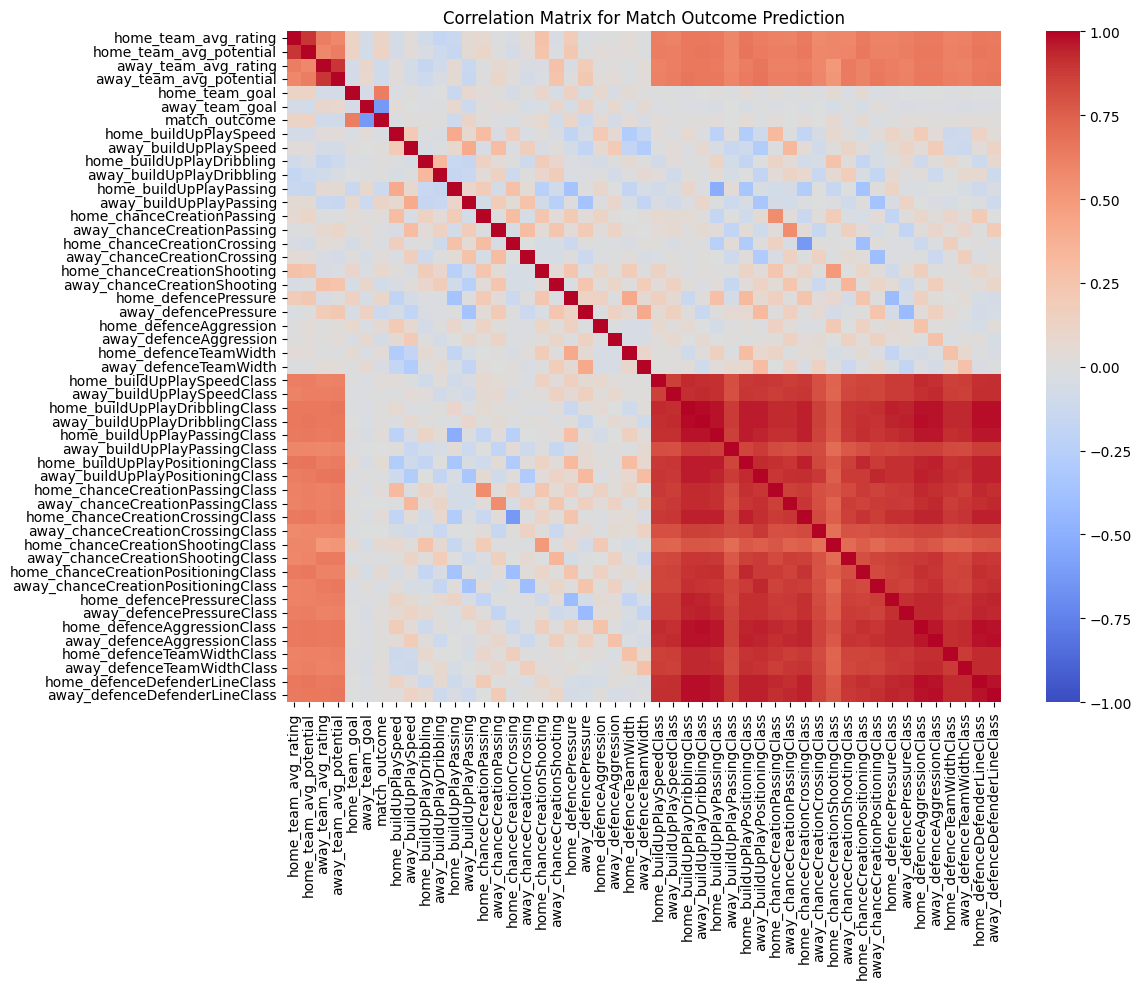

match_outcome                          1.000000
home_team_goal                         0.626126
home_team_avg_potential                0.125314
home_team_avg_rating                   0.112424
away_buildUpPlayPassing                0.111684
home_defencePressure                   0.105439
home_chanceCreationShooting            0.072100
home_chanceCreationShootingClass       0.058646
home_defenceAggression                 0.057516
home_chanceCreationPositioningClass    0.051384
home_buildUpPlayPositioningClass       0.039500
home_defenceTeamWidth                  0.037717
home_chanceCreationPassingClass        0.028820
away_chanceCreationCrossing            0.028555
home_buildUpPlayPassingClass           0.025682
away_defencePressureClass              0.025029
away_defenceTeamWidthClass             0.024605
home_buildUpPlaySpeedClass             0.024179
home_chanceCreationCrossingClass       0.023907
home_chanceCreationPassing             0.022591
home_defenceDefenderLineClass          0

In [13]:

correlation_matrix = df_combined[features_for_correlation].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix for Match Outcome Prediction')
plt.tight_layout()
plt.show()

print(correlation_matrix['match_outcome'].sort_values(ascending=False))


In [14]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# from sklearn.preprocessing import StandardScaler
# from sklearn.neural_network import MLPClassifier


# features = [
#     'home_team_avg_rating', 'home_team_avg_potential',
#     'away_team_avg_rating', 'away_team_avg_potential'
# ]

# df_combined = df_combined.fillna(0)
# #print(df_combined.isnull().sum())

# X = df_combined[features]
# y = df_combined['match_outcome']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# models = {
#     'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
#     #'XGBoost': XGBClassifier(n_estimators=100, random_state=42),
#     'Neural Network': MLPClassifier(hidden_layer_sizes=(500, 100), max_iter=500, random_state=42)
# }

# results = {}

# for name, model in models.items():
#     model.fit(X_train_scaled, y_train)
    
#     y_pred = model.predict(X_test_scaled)
    
#     accuracy = accuracy_score(y_test, y_pred)
    
#     results[name] = {
#         'accuracy': accuracy,
#         'confusion_matrix': confusion_matrix(y_test, y_pred),
#         'classification_report': classification_report(y_test, y_pred, target_names=['Away Win', 'Draw', 'Home Win'], output_dict=True)
#     }
    
#     print(f"\n{name} Results:")
#     print(f"Accuracy: {accuracy:.4f}")
#     print("\nClassification Report:")
#     print(classification_report(y_test, y_pred, target_names=['Away Win', 'Draw', 'Home Win']))
#     print("\nConfusion Matrix:")
#     print(confusion_matrix(y_test, y_pred))

# plt.figure(figsize=(10, 6))
# accuracies = [results[model]['accuracy'] for model in models]
# plt.bar(models.keys(), accuracies)
# plt.title('Model Accuracy Comparison')
# plt.ylabel('Accuracy')
# plt.ylim(0, 1)
# for i, v in enumerate(accuracies):
#     plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
# plt.show()

# class_names = ['Away Win', 'Draw', 'Home Win']

# fig, axes = plt.subplots(1, 2, figsize=(20, 5))
# for i, (name, model) in enumerate(models.items()):
#     sns.heatmap(results[name]['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[i],
#                 xticklabels=class_names, yticklabels=class_names)
#     axes[i].set_title(f'{name} Confusion Matrix')
#     axes[i].set_xlabel('Predicted')
#     axes[i].set_ylabel('Actual')
# plt.tight_layout()
# plt.show()

# f1_scores = {name: results[name]['classification_report']['weighted avg']['f1-score'] for name in models}
# plt.figure(figsize=(10, 6))
# plt.bar(f1_scores.keys(), f1_scores.values())
# plt.title('Weighted Average F1-Score Comparison')
# plt.ylabel('F1-Score')
# plt.ylim(0, 1)
# for i, v in enumerate(f1_scores.values()):
#     plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
# plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Early stopping utility
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None

    def check(self, current_loss):
        if self.best_loss is None or (self.best_loss - current_loss) > self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
            return False  # Continue training
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True  # Stop training
            return False

# Neural network architecture
class MatchOutcomeNN(nn.Module):
    def __init__(self, input_size):
        super(MatchOutcomeNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, 3)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        x = self.fc5(x)
        return x

def train_pytorch_nn(model, X_train, y_train, X_test, y_test, num_epochs=50, batch_size=32):
    y_train = y_train.replace({-1: 0, 1: 1, 0: 2})
    y_test = y_test.replace({-1: 0, 1: 1, 0: 2})
    
    # Class weights to handle imbalance
    class_weights = torch.tensor([1.5, 1.0, 1.2])
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)

    # DataLoader for batching
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    # Optimizer and scheduler
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
    scheduler = StepLR(optimizer, step_size=100, gamma=0.5)
    early_stopping = EarlyStopping(patience=20, min_delta=0.001)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            running_loss += loss.item()
        
        scheduler.step()
        
        if (epoch+1) % 10 == 0:
            train_accuracy = correct_predictions / total_samples
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Training Accuracy: {train_accuracy:.4f}')

    # Evaluation
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        probabilities = nn.Softmax(dim=1)(outputs)
        _, predicted = torch.max(outputs, 1)
        
        predicted_mapped = predicted.numpy()
        predicted_mapped = np.where(predicted_mapped == 0, -1, predicted_mapped)
        predicted_mapped = np.where(predicted_mapped == 2, 0, predicted_mapped)
        predicted_mapped = np.where(predicted_mapped == 1, 1, predicted_mapped)

        nn_probabilities = probabilities.numpy()
    
    return predicted_mapped, nn_probabilities

# Data preparation
features = [
    'home_team_avg_rating', 'home_team_avg_potential',
    'away_team_avg_rating', 'away_team_avg_potential'
]
team_attr = [
    'buildUpPlaySpeed', 'buildUpPlayDribbling', 'buildUpPlayPassing', 
    'chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting', 
    'defencePressure', 'defenceAggression', 'defenceTeamWidth',
    'buildUpPlaySpeedClass', 'buildUpPlayDribblingClass',
    'buildUpPlayPassingClass', 'buildUpPlayPositioningClass',
    'chanceCreationPassingClass', 'chanceCreationCrossingClass',
    'chanceCreationShootingClass', 'chanceCreationPositioningClass',
    'defencePressureClass', 'defenceAggressionClass',
    'defenceTeamWidthClass', 'defenceDefenderLineClass'
]
features.extend([f'home_{attr}' for attr in team_attr])
features.extend([f'away_{attr}' for attr in team_attr])

df_combined = df_combined.fillna(0)

X = df_combined[features]
y = df_combined['match_outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Train individual models and get metrics
rf_model.fit(X_train_scaled, y_train)
rf_predictions = rf_model.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)
rf_class_report = classification_report(y_test, rf_predictions, target_names=['Away Win', 'Draw', 'Home Win'])

print("\nRandom Forest Results:")
print(f"Accuracy: {rf_accuracy:.4f}")
print("Classification Report:")
print(rf_class_report)
print("Confusion Matrix:")
print(rf_conf_matrix)

gb_classifier.fit(X_train_scaled, y_train)
gb_predictions = gb_classifier.predict(X_test_scaled)
gb_accuracy = accuracy_score(y_test, gb_predictions)
gb_conf_matrix = confusion_matrix(y_test, gb_predictions)
gb_class_report = classification_report(y_test, gb_predictions, target_names=['Away Win', 'Draw', 'Home Win'])

print("\nGradient Boosting Results:")
print(f"Accuracy: {gb_accuracy:.4f}")
print("Classification Report:")
print(gb_class_report)
print("Confusion Matrix:")
print(gb_conf_matrix)

input_size = X_train_scaled.shape[1]
nn_model = MatchOutcomeNN(input_size)
nn_predictions, nn_probabilities = train_pytorch_nn(nn_model, X_train_scaled, y_train, X_test_scaled, y_test, num_epochs=50)

# Since predictions are already mapped, use them directly
nn_accuracy = accuracy_score(y_test, nn_predictions)
nn_conf_matrix = confusion_matrix(y_test, nn_predictions)
nn_class_report = classification_report(y_test, nn_predictions, target_names=['Away Win', 'Draw', 'Home Win'])

print("\nNeural Network Results:")
print(f"Accuracy: {nn_accuracy:.4f}")
print("Classification Report:")
print(nn_class_report)
print("Confusion Matrix:")
print(nn_conf_matrix)

print("\nNeural Network Results:")
print(f"Accuracy: {nn_accuracy:.4f}")
print("Classification Report:")
print(nn_class_report)
print("Confusion Matrix:")
print(nn_conf_matrix)

# Plot confusion matrices for each model
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
model_names = ["Random Forest", "Gradient Boosting", "Neural Network"]
conf_matrices = [rf_conf_matrix, gb_conf_matrix, nn_conf_matrix]

for i, (ax, conf_matrix, model_name) in enumerate(zip(axes.flatten(), conf_matrices, model_names)):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Away Win', 'Draw', 'Home Win'],
                yticklabels=['Away Win', 'Draw', 'Home Win'])
    ax.set_title(f'{model_name} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()


Random Forest Results:
Accuracy: 0.4549
Classification Report:
              precision    recall  f1-score   support

    Away Win       0.41      0.39      0.40      1187
        Draw       0.27      0.19      0.22      1090
    Home Win       0.53      0.65      0.58      1935

    accuracy                           0.45      4212
   macro avg       0.41      0.41      0.40      4212
weighted avg       0.43      0.45      0.44      4212

Confusion Matrix:
[[ 459  218  510]
 [ 291  203  596]
 [ 361  320 1254]]

Gradient Boosting Results:
Accuracy: 0.5021
Classification Report:
              precision    recall  f1-score   support

    Away Win       0.49      0.35      0.41      1187
        Draw       0.26      0.02      0.04      1090
    Home Win       0.51      0.87      0.64      1935

    accuracy                           0.50      4212
   macro avg       0.42      0.41      0.36      4212
weighted avg       0.44      0.50      0.42      4212

Confusion Matrix:
[[ 419   23  74

Epoch [10/500], Loss: 1.0995, Training Accuracy: 0.3565


Epoch [20/500], Loss: 1.0995, Training Accuracy: 0.3483


Epoch [30/500], Loss: 1.0992, Training Accuracy: 0.3392


Epoch [40/500], Loss: 1.0993, Training Accuracy: 0.3510


Epoch [50/500], Loss: 1.0992, Training Accuracy: 0.3542


Epoch [60/500], Loss: 1.0993, Training Accuracy: 0.3635


Epoch [70/500], Loss: 1.0992, Training Accuracy: 0.3522


Epoch [80/500], Loss: 1.0993, Training Accuracy: 0.3378


Epoch [90/500], Loss: 1.0994, Training Accuracy: 0.3631


Epoch [100/500], Loss: 1.0993, Training Accuracy: 0.3657


Epoch [110/500], Loss: 1.0990, Training Accuracy: 0.3750


Epoch [120/500], Loss: 1.0988, Training Accuracy: 0.3515


Epoch [130/500], Loss: 1.0991, Training Accuracy: 0.3765


Epoch [140/500], Loss: 1.0990, Training Accuracy: 0.3438


Epoch [150/500], Loss: 1.0989, Training Accuracy: 0.3343


KeyboardInterrupt: 

In [25]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# Prepare the data
features = [
    'home_team_avg_rating', 'home_team_avg_potential',
    'away_team_avg_rating', 'away_team_avg_potential'
]
team_attr = [
    'buildUpPlaySpeed', 'buildUpPlayDribbling', 'buildUpPlayPassing', 
    'chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting', 
    'defencePressure', 'defenceAggression', 'defenceTeamWidth',
    'buildUpPlaySpeedClass', 'buildUpPlayDribblingClass',
    'buildUpPlayPassingClass', 'buildUpPlayPositioningClass',
    'chanceCreationPassingClass', 'chanceCreationCrossingClass',
    'chanceCreationShootingClass', 'chanceCreationPositioningClass',
    'defencePressureClass', 'defenceAggressionClass',
    'defenceTeamWidthClass', 'defenceDefenderLineClass'
]
features.extend([f'home_{attr}' for attr in team_attr])
features.extend([f'away_{attr}' for attr in team_attr])

df_combined = df_combined.fillna(0)

X = df_combined[features]
y = df_combined['match_outcome']

# Map original labels: -1 -> 0, 0 -> 1, 1 -> 2
label_map = {-1: 0, 0: 1, 1: 2}
inverse_label_map = {0: -1, 1: 0, 2: 1}
y_mapped = y.map(label_map)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y_mapped, test_size=0.2, random_state=42)

from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_grid = {
    'n_d': [8, 16, 32],
    'n_a': [8, 16, 32],
    'n_steps': [3, 5, 7],
    'gamma': [1.0, 1.5, 2.0],
    'momentum': [0.02, 0.1, 0.3],
    'optimizer_params': [{'lr': 0.01}, {'lr': 0.005}, {'lr': 0.001}],
    'mask_type': ['sparsemax', 'entmax'],
}

# Initialize TabNet with a randomized search for hyperparameter tuning
tabnet_model = TabNetClassifier()

# Use RandomizedSearchCV for efficient hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=tabnet_model, param_distributions=param_grid,
    n_iter=10, scoring='accuracy', cv=3, verbose=1, n_jobs=-1
)

# Fit on training data
random_search.fit(X_train.values, y_train.values)

# Get the best parameters
best_params = random_search.best_params_
print("Best parameters:", best_params)
# Initialize TabNet Classifier
best_params = random_search.best_params_
print("Best parameters:", best_params)



Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/svrao3/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/home/svrao3/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/svrao3/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/svrao3/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/svrao3/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/svrao3/.local/lib/python3.10/site-pa

epoch 0  | loss: 1.54558 |  0:00:00s
epoch 0  | loss: 1.55051 |  0:00:00s
epoch 0  | loss: 2.26799 |  0:00:01s
epoch 0  | loss: 1.54472 |  0:00:00s
epoch 0  | loss: 4.22595 |  0:00:01s
epoch 0  | loss: 4.16969 |  0:00:01s
epoch 0  | loss: 3.22849 |  0:00:01s
epoch 0  | loss: 3.29418 |  0:00:01s
epoch 0  | loss: 4.14184 |  0:00:01s
epoch 0  | loss: 2.26481 |  0:00:01s
epoch 1  | loss: 1.15555 |  0:00:01s
epoch 1  | loss: 1.13307 |  0:00:01s
epoch 1  | loss: 1.13936 |  0:00:01s
epoch 0  | loss: 2.22214 |  0:00:01s
epoch 0  | loss: 2.60592 |  0:00:01s
epoch 0  | loss: 2.63009 |  0:00:01s
epoch 0  | loss: 2.61759 |  0:00:01s
epoch 1  | loss: 3.74098 |  0:00:02s
epoch 1  | loss: 1.48366 |  0:00:02s
epoch 1  | loss: 1.27118 |  0:00:02s
epoch 1  | loss: 3.77146 |  0:00:02s
epoch 2  | loss: 1.09494 |  0:00:02s
epoch 2  | loss: 1.10849 |  0:00:02s
epoch 1  | loss: 1.48663 |  0:00:02s
epoch 1  | loss: 3.69342 |  0:00:02s
epoch 2  | loss: 1.09401 |  0:00:02s
epoch 1  | loss: 1.26287 |  0:00:03s
e

/home/svrao3/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/svrao3/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 4  | loss: 1.06609 |  0:00:04s
epoch 4  | loss: 1.0651  |  0:00:04s
epoch 2  | loss: 1.16588 |  0:00:04s
epoch 3  | loss: 2.97209 |  0:00:04s
epoch 3  | loss: 3.02756 |  0:00:04s
epoch 3  | loss: 1.21689 |  0:00:04s
epoch 2  | loss: 1.11777 |  0:00:04s
epoch 2  | loss: 1.17031 |  0:00:04s
epoch 5  | loss: 1.04839 |  0:00:05s
epoch 3  | loss: 2.97315 |  0:00:05s
epoch 3  | loss: 1.21865 |  0:00:05s
epoch 5  | loss: 1.0541  |  0:00:05s
epoch 5  | loss: 1.05802 |  0:00:05s
epoch 2  | loss: 1.1506  |  0:00:05s
epoch 2  | loss: 1.13051 |  0:00:05s
epoch 3  | loss: 1.10973 |  0:00:06s
epoch 6  | loss: 1.04445 |  0:00:06s
epoch 4  | loss: 2.75088 |  0:00:06s
epoch 4  | loss: 2.64611 |  0:00:06s
epoch 4  | loss: 1.17008 |  0:00:06s
epoch 6  | loss: 1.04703 |  0:00:06s
epoch 0  | loss: 1.87022 |  0:00:02s
epoch 0  | loss: 3.32005 |  0:00:02s
epoch 3  | loss: 1.10881 |  0:00:06s
epoch 6  | loss: 1.04873 |  0:00:06s
epoch 4  | loss: 2.65445 |  0:00:06s
epoch 4  | loss: 1.1668  |  0:00:06s
e

/home/svrao3/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 56 | loss: 1.0147  |  0:01:43s
epoch 68 | loss: 1.03191 |  0:01:39s
epoch 72 | loss: 1.01986 |  0:01:43s
epoch 72 | loss: 1.05553 |  0:01:43s
epoch 72 | loss: 1.05549 |  0:01:43s
epoch 56 | loss: 1.00858 |  0:01:43s
epoch 71 | loss: 1.06271 |  0:01:43s


/home/svrao3/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/svrao3/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 72 | loss: 1.0249  |  0:01:44s
epoch 56 | loss: 1.047   |  0:01:44s
epoch 57 | loss: 1.03211 |  0:01:44s
epoch 56 | loss: 1.01078 |  0:01:44s
epoch 69 | loss: 1.02985 |  0:01:40s
epoch 69 | loss: 1.03107 |  0:01:40s
epoch 73 | loss: 1.01922 |  0:01:44s
epoch 0  | loss: 1.82948 |  0:00:01s
epoch 57 | loss: 1.03318 |  0:01:45s
epoch 73 | loss: 1.05468 |  0:01:45s
epoch 72 | loss: 1.06836 |  0:01:45s
epoch 73 | loss: 1.05406 |  0:01:45s
epoch 57 | loss: 1.01325 |  0:01:45s
epoch 73 | loss: 1.0235  |  0:01:45s
epoch 0  | loss: 1.88009 |  0:00:01s
epoch 57 | loss: 1.00863 |  0:01:45s
epoch 0  | loss: 2.44126 |  0:00:01s
epoch 70 | loss: 1.03186 |  0:01:41s
epoch 57 | loss: 1.04216 |  0:01:46s
epoch 74 | loss: 1.01951 |  0:01:46s
epoch 1  | loss: 1.63172 |  0:00:02s
epoch 70 | loss: 1.03069 |  0:01:42s
epoch 58 | loss: 1.03134 |  0:01:46s
epoch 74 | loss: 1.05873 |  0:01:46s
epoch 57 | loss: 1.00954 |  0:01:46s
epoch 73 | loss: 1.07232 |  0:01:46s
epoch 74 | loss: 1.05834 |  0:01:46s
e

/home/svrao3/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/svrao3/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/svrao3/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 79 | loss: 1.0319  |  0:02:25s
epoch 79 | loss: 1.03233 |  0:02:26s
epoch 28 | loss: 1.06598 |  0:00:42s
epoch 28 | loss: 1.07262 |  0:00:42s
epoch 28 | loss: 1.027   |  0:00:41s
epoch 79 | loss: 1.01281 |  0:02:25s


/home/svrao3/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 98 | loss: 1.02481 |  0:02:22s
epoch 79 | loss: 1.0025  |  0:02:26s
epoch 98 | loss: 1.02407 |  0:02:22s
epoch 79 | loss: 1.03916 |  0:02:26s
epoch 0  | loss: 2.43555 |  0:00:01s
epoch 0  | loss: 3.43733 |  0:00:01s
epoch 0  | loss: 2.47031 |  0:00:01s
epoch 79 | loss: 1.00709 |  0:02:26s
epoch 29 | loss: 1.06738 |  0:00:43s
epoch 29 | loss: 1.07157 |  0:00:43s
epoch 0  | loss: 3.42939 |  0:00:01s
epoch 29 | loss: 1.02613 |  0:00:43s


/home/svrao3/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 80 | loss: 1.02867 |  0:02:28s
epoch 80 | loss: 1.02694 |  0:02:27s
epoch 80 | loss: 1.01263 |  0:02:27s
epoch 99 | loss: 1.02475 |  0:02:23s
epoch 99 | loss: 1.0213  |  0:02:23s
epoch 1  | loss: 1.26617 |  0:00:02s
epoch 1  | loss: 2.05009 |  0:00:02s
epoch 1  | loss: 1.24779 |  0:00:02s
epoch 80 | loss: 1.00198 |  0:02:28s
epoch 80 | loss: 1.03522 |  0:02:28s
epoch 30 | loss: 1.06593 |  0:00:45s
epoch 30 | loss: 1.06297 |  0:00:44s
epoch 0  | loss: 3.51517 |  0:00:01s
epoch 30 | loss: 1.02787 |  0:00:44s
epoch 80 | loss: 1.00801 |  0:02:28s
epoch 1  | loss: 1.99842 |  0:00:02s
epoch 81 | loss: 1.02686 |  0:02:29s
epoch 81 | loss: 1.03047 |  0:02:29s
epoch 2  | loss: 1.43348 |  0:00:04s
epoch 2  | loss: 1.11484 |  0:00:04s
epoch 2  | loss: 1.13859 |  0:00:04s
epoch 81 | loss: 1.01434 |  0:02:29s
epoch 31 | loss: 1.06349 |  0:00:46s
epoch 31 | loss: 1.06137 |  0:00:46s
epoch 1  | loss: 2.07782 |  0:00:02s
epoch 81 | loss: 1.00196 |  0:02:29s
epoch 31 | loss: 1.02655 |  0:00:46s
e

/home/svrao3/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/svrao3/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 3  | loss: 1.23798 |  0:00:05s
epoch 3  | loss: 1.08591 |  0:00:05s
epoch 3  | loss: 1.09247 |  0:00:05s
epoch 82 | loss: 1.02519 |  0:02:31s
epoch 82 | loss: 1.0292  |  0:02:31s
epoch 2  | loss: 1.39874 |  0:00:04s
epoch 32 | loss: 1.06202 |  0:00:48s
epoch 32 | loss: 1.06273 |  0:00:47s
epoch 82 | loss: 1.01156 |  0:02:31s
epoch 32 | loss: 1.0252  |  0:00:47s
epoch 3  | loss: 1.19925 |  0:00:05s
epoch 0  | loss: 1.38331 |  0:00:01s
epoch 0  | loss: 1.41806 |  0:00:01s
epoch 82 | loss: 1.00048 |  0:02:31s
epoch 82 | loss: 1.0403  |  0:02:32s
epoch 4  | loss: 1.0793  |  0:00:06s
epoch 4  | loss: 1.07647 |  0:00:06s
epoch 4  | loss: 1.16007 |  0:00:06s
epoch 82 | loss: 1.01061 |  0:02:32s
epoch 83 | loss: 1.02415 |  0:02:32s
epoch 1  | loss: 1.10811 |  0:00:02s
epoch 33 | loss: 1.06041 |  0:00:49s
epoch 1  | loss: 1.11104 |  0:00:02s
epoch 3  | loss: 1.20023 |  0:00:05s
epoch 33 | loss: 1.05579 |  0:00:49sepoch 33 | loss: 1.03069 |  0:00:48s

epoch 83 | loss: 1.03209 |  0:02:33s
e

/home/svrao3/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/svrao3/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 27 | loss: 1.03584 |  0:00:39s


/home/svrao3/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 26 | loss: 1.04113 |  0:00:38s
epoch 34 | loss: 1.00842 |  0:00:35s


/home/svrao3/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 56 | loss: 1.03673 |  0:01:22s
epoch 56 | loss: 1.04345 |  0:01:22s
epoch 27 | loss: 1.04113 |  0:00:40s
epoch 34 | loss: 1.01125 |  0:00:35s
epoch 0  | loss: 1.42246 |  0:00:00s
epoch 0  | loss: 1.25623 |  0:00:00s
epoch 56 | loss: 1.01745 |  0:01:22s
epoch 28 | loss: 1.02391 |  0:00:40s
epoch 0  | loss: 1.25276 |  0:00:00s
epoch 28 | loss: 1.03274 |  0:00:40s
epoch 28 | loss: 1.03551 |  0:00:40s
epoch 0  | loss: 1.24173 |  0:00:00s
epoch 35 | loss: 1.00967 |  0:00:35s
epoch 35 | loss: 1.01199 |  0:00:36s
epoch 1  | loss: 1.10909 |  0:00:01s
epoch 27 | loss: 1.03969 |  0:00:39s
epoch 1  | loss: 1.16787 |  0:00:01s
epoch 57 | loss: 1.03459 |  0:01:23s
epoch 1  | loss: 1.17325 |  0:00:01s
epoch 28 | loss: 1.04273 |  0:00:41s
epoch 57 | loss: 1.04211 |  0:01:23s
epoch 57 | loss: 1.0175  |  0:01:23s
epoch 29 | loss: 1.02629 |  0:00:41s
epoch 29 | loss: 1.03028 |  0:00:42s
epoch 1  | loss: 1.15826 |  0:00:01s
epoch 36 | loss: 1.01    |  0:00:36s
epoch 29 | loss: 1.03527 |  0:00:42s
e

/home/svrao3/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 2.21104 |  0:00:01s
epoch 1  | loss: 1.1519  |  0:00:03s
epoch 2  | loss: 1.07622 |  0:00:05s
epoch 3  | loss: 1.05362 |  0:00:06s
epoch 4  | loss: 1.04582 |  0:00:08s
epoch 5  | loss: 1.04144 |  0:00:10s
epoch 6  | loss: 1.03926 |  0:00:12s
epoch 7  | loss: 1.03954 |  0:00:13s
epoch 8  | loss: 1.03613 |  0:00:15s
epoch 9  | loss: 1.0309  |  0:00:17s
epoch 10 | loss: 1.03264 |  0:00:18s
epoch 11 | loss: 1.03268 |  0:00:20s
epoch 12 | loss: 1.0325  |  0:00:21s
epoch 13 | loss: 1.03109 |  0:00:23s
epoch 14 | loss: 1.02925 |  0:00:25s
epoch 15 | loss: 1.02707 |  0:00:27s
epoch 16 | loss: 1.02627 |  0:00:29s
epoch 17 | loss: 1.02566 |  0:00:31s
epoch 18 | loss: 1.02184 |  0:00:32s
epoch 19 | loss: 1.02182 |  0:00:34s
epoch 20 | loss: 1.02265 |  0:00:36s
epoch 21 | loss: 1.02113 |  0:00:38s
epoch 22 | loss: 1.01995 |  0:00:39s
epoch 23 | loss: 1.02052 |  0:00:41s
epoch 24 | loss: 1.01861 |  0:00:43s
epoch 25 | loss: 1.02132 |  0:00:44s
epoch 26 | loss: 1.01709 |  0:00:46s
e

/home/svrao3/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/home/svrao3/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 2.18668 |  0:00:01s
epoch 1  | loss: 1.151   |  0:00:03s
epoch 2  | loss: 1.07681 |  0:00:04s
epoch 3  | loss: 1.05651 |  0:00:06s
epoch 4  | loss: 1.04426 |  0:00:08s
epoch 5  | loss: 1.03688 |  0:00:10s
epoch 6  | loss: 1.03323 |  0:00:11s
epoch 7  | loss: 1.0313  |  0:00:13s
epoch 8  | loss: 1.03289 |  0:00:15s
epoch 9  | loss: 1.031   |  0:00:16s
epoch 10 | loss: 1.02821 |  0:00:18s
epoch 11 | loss: 1.03146 |  0:00:20s
epoch 12 | loss: 1.02786 |  0:00:22s
epoch 13 | loss: 1.02555 |  0:00:24s
epoch 14 | loss: 1.02452 |  0:00:26s
epoch 15 | loss: 1.02264 |  0:00:27s
epoch 16 | loss: 1.02358 |  0:00:29s
epoch 17 | loss: 1.02262 |  0:00:31s
epoch 18 | loss: 1.02024 |  0:00:32s
epoch 19 | loss: 1.02011 |  0:00:34s
epoch 20 | loss: 1.02706 |  0:00:36s
epoch 21 | loss: 1.0198  |  0:00:37s
epoch 22 | loss: 1.01974 |  0:00:39s
epoch 23 | loss: 1.01781 |  0:00:41s
epoch 24 | loss: 1.01731 |  0:00:43s
epoch 25 | loss: 1.01513 |  0:00:44s
epoch 26 | loss: 1.01559 |  0:00:46s
e

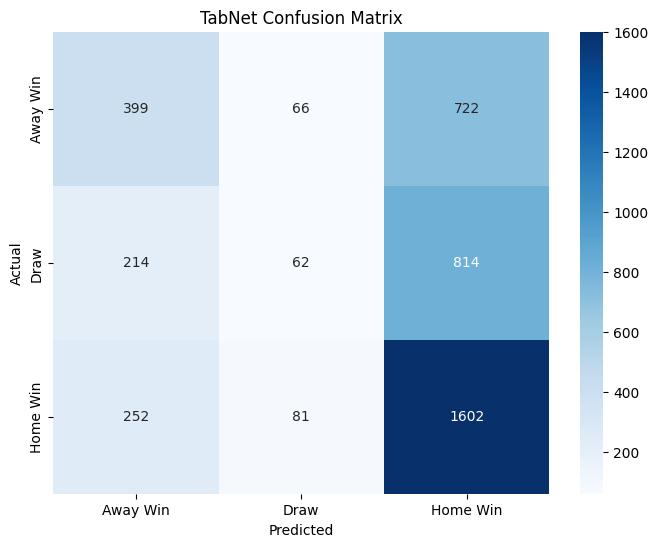

In [27]:
# Step 2: Initialize a new TabNet model with these best parameters
tabnet_model = TabNetClassifier(
    n_d=best_params['n_d'],
    n_a=best_params['n_a'],
    n_steps=best_params['n_steps'],
    gamma=best_params['gamma'],
    momentum=best_params['momentum'],
    optimizer_params=best_params['optimizer_params'],
    mask_type=best_params['mask_type'],
)

# Training TabNet
tabnet_model.fit(
    X_train.values, y_train.values,
    max_epochs=200,
    patience=20,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
)


# Predictions and Evaluation
tabnet_preds_mapped = tabnet_model.predict(X_test.values)
tabnet_preds = pd.Series(tabnet_preds_mapped).map(inverse_label_map)  # Map back to original labels

# Calculate accuracy
tabnet_accuracy = accuracy_score(y_test.map(inverse_label_map), tabnet_preds)
tabnet_conf_matrix = confusion_matrix(y_test.map(inverse_label_map), tabnet_preds)
tabnet_class_report = classification_report(y_test.map(inverse_label_map), tabnet_preds, target_names=['Away Win', 'Draw', 'Home Win'])

print("\nTabNet Results:")
print(f"Accuracy: {tabnet_accuracy:.4f}")
print("Classification Report:")
print(tabnet_class_report)
print("Confusion Matrix:")
print(tabnet_conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(tabnet_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Away Win', 'Draw', 'Home Win'],
            yticklabels=['Away Win', 'Draw', 'Home Win'])
plt.title('TabNet Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
import torch
import torch.nn as nn
from pytorch_tabnet.tab_model import TabNetClassifier

# Assuming `X_train`, `y_train`, `X_test`, and `y_test` are already prepared

# Define the TabTransformer model with appropriate configurations
class TabTransformer(nn.Module):
    def __init__(self, input_dim, n_layers=2, n_heads=4, hidden_dim=64, dropout=0.1):
        super(TabTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=n_heads, dropout=dropout, dim_feedforward=hidden_dim*2
        )
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=n_layers)
        self.fc = nn.Linear(hidden_dim, 3)  # 3 classes for -1, 0, 1 mapped to 0, 1, 2
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.transformer_encoder(x.unsqueeze(1)).squeeze(1)
        x = self.fc(x)
        return x

# Initialize model, loss, and optimizer
input_dim = X_train.shape[1]
tab_transformer = TabTransformer(input_dim=input_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(tab_transformer.parameters(), lr=0.001)

# Training loop
def train_model(model, X_train, y_train, num_epochs=200, batch_size=64):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i in range(0, len(X_train), batch_size):
            batch_x = torch.tensor(X_train[i:i + batch_size].values, dtype=torch.float32)
            batch_y = torch.tensor(y_train[i:i + batch_size].values, dtype=torch.long)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / (i // batch_size):.4f}')

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        batch_x = torch.tensor(X_test.values, dtype=torch.float32)
        outputs = model(batch_x)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == torch.tensor(y_test.values)).float().mean()
        print(f'Accuracy: {accuracy:.4f}')
        print(confusion_matrix(y_test, predicted))
        print(classification_report(y_test, predicted))

# Train and evaluate
train_model(tab_transformer, X_train, y_train, num_epochs=500)
evaluate_model(tab_transformer, X_test, y_test)

/home/svrao3/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/200, Loss: 1.0832
Epoch 2/200, Loss: 1.0732
Epoch 3/200, Loss: 1.0718
Epoch 4/200, Loss: 1.0654
Epoch 5/200, Loss: 1.0558
Epoch 6/200, Loss: 1.0528
Epoch 7/200, Loss: 1.0490
Epoch 8/200, Loss: 1.0460
Epoch 9/200, Loss: 1.0430
Epoch 10/200, Loss: 1.0440
Epoch 11/200, Loss: 1.0438
Epoch 12/200, Loss: 1.0420
Epoch 13/200, Loss: 1.0408
Epoch 14/200, Loss: 1.0395
Epoch 15/200, Loss: 1.0375
Epoch 16/200, Loss: 1.0363
Epoch 17/200, Loss: 1.0371
Epoch 18/200, Loss: 1.0388
Epoch 19/200, Loss: 1.0367
Epoch 20/200, Loss: 1.0367
Epoch 21/200, Loss: 1.0361
Epoch 22/200, Loss: 1.0346
Epoch 23/200, Loss: 1.0356
Epoch 24/200, Loss: 1.0349
Epoch 25/200, Loss: 1.0353
Epoch 26/200, Loss: 1.0345
Epoch 27/200, Loss: 1.0355
Epoch 28/200, Loss: 1.0346
Epoch 29/200, Loss: 1.0355
Epoch 30/200, Loss: 1.0356
Epoch 31/200, Loss: 1.0355
Epoch 32/200, Loss: 1.0334
Epoch 33/200, Loss: 1.0371
Epoch 34/200, Loss: 1.0360
Epoch 35/200, Loss: 1.0359
Epoch 36/200, Loss: 1.0350
Epoch 37/200, Loss: 1.0332
Epoch 38/2